# Overview

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import keras
import scikeras

In [2]:
#suppress warnings to reduce output clutter
import warnings
from tensorflow import get_logger
warnings.filterwarnings('ignore')
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
heart_disease_df = pd.read_csv("heart.csv", index_col=False)
heart_disease_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


We want a heatmap to get an idea of any inherent correlations with our data. This will give us an idea of which features will positively impact the target and which will impact it negatively. For this, we need out data to be exclusively numerical since categorical data is not compatiable with seaborn's heatmap. To do so we'll first need to one hot encode the following columns:

*   Sex
*   ChestPainType
*   RestingECG
*   ST_Slope

Additionally ExerciseAngina needs to be changed such that Y=1, N=0.\
We should also note that we will need to use a classifier since our target column (HeartDisease) are distinct, binary to be speciffic. A classifier is ideal as opposed to a regressor as our target data is effectively true or false.

In [4]:
heart_disease_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


a quick look at the description of the database tells us that we won't have too much cleanup

In [5]:
#one-hot encode Sex
one_hot_Sex = pd.get_dummies(heart_disease_df['Sex'], prefix='Sex', dtype=int)
one_hot_heart_disease_df = heart_disease_df.join(one_hot_Sex)
one_hot_heart_disease_df = one_hot_heart_disease_df.drop('Sex', axis=1)
one_hot_heart_disease_df

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M
0,40,ATA,140,289,0,Normal,172,N,0.0,Up,0,0,1
1,49,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1,0
2,37,ATA,130,283,0,ST,98,N,0.0,Up,0,0,1
3,48,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,1,0
4,54,NAP,150,195,0,Normal,122,N,0.0,Up,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,TA,110,264,0,Normal,132,N,1.2,Flat,1,0,1
914,68,ASY,144,193,1,Normal,141,N,3.4,Flat,1,0,1
915,57,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,0,1
916,57,ATA,130,236,0,LVH,174,N,0.0,Flat,1,1,0


In [6]:
#one-hot encode ChestPainType
one_hot_ChestPainType = pd.get_dummies(heart_disease_df['ChestPainType'], prefix='ChestPainType', dtype=int)
one_hot_heart_disease_df = one_hot_heart_disease_df.join(one_hot_ChestPainType)
one_hot_heart_disease_df = one_hot_heart_disease_df.drop('ChestPainType', axis=1)
one_hot_heart_disease_df

,Age,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,40,140,289,0,Normal,172,N,0.0,Up,0,0,1,0,1,0,0
1,49,160,180,0,Normal,156,N,1.0,Flat,1,1,0,0,0,1,0
2,37,130,283,0,ST,98,N,0.0,Up,0,0,1,0,1,0,0
3,48,138,214,0,Normal,108,Y,1.5,Flat,1,1,0,1,0,0,0
4,54,150,195,0,Normal,122,N,0.0,Up,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,Normal,132,N,1.2,Flat,1,0,1,0,0,0,1
914,68,144,193,1,Normal,141,N,3.4,Flat,1,0,1,1,0,0,0
915,57,130,131,0,Normal,115,Y,1.2,Flat,1,0,1,1,0,0,0
916,57,130,236,0,LVH,174,N,0.0,Flat,1,1,0,0,1,0,0


In [7]:
#one-hot encode RestingECG
one_hot_RestingECG = pd.get_dummies(heart_disease_df['RestingECG'], prefix='RestingECG', dtype=int)
one_hot_heart_disease_df = one_hot_heart_disease_df.join(one_hot_RestingECG)
one_hot_heart_disease_df = one_hot_heart_disease_df.drop('RestingECG', axis=1)
one_hot_heart_disease_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,140,289,0,172,N,0.0,Up,0,0,1,0,1,0,0,0,1,0
1,49,160,180,0,156,N,1.0,Flat,1,1,0,0,0,1,0,0,1,0
2,37,130,283,0,98,N,0.0,Up,0,0,1,0,1,0,0,0,0,1
3,48,138,214,0,108,Y,1.5,Flat,1,1,0,1,0,0,0,0,1,0
4,54,150,195,0,122,N,0.0,Up,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,N,1.2,Flat,1,0,1,0,0,0,1,0,1,0
914,68,144,193,1,141,N,3.4,Flat,1,0,1,1,0,0,0,0,1,0
915,57,130,131,0,115,Y,1.2,Flat,1,0,1,1,0,0,0,0,1,0
916,57,130,236,0,174,N,0.0,Flat,1,1,0,0,1,0,0,1,0,0


In [8]:
#one-hot encode ST_Slope
one_hot_ST_Slope = pd.get_dummies(heart_disease_df['ST_Slope'], prefix='ST_Slope', dtype=int)
one_hot_heart_disease_df = one_hot_heart_disease_df.join(one_hot_ST_Slope)
one_hot_heart_disease_df = one_hot_heart_disease_df.drop('ST_Slope', axis=1)
one_hot_heart_disease_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,N,0.0,0,0,1,0,1,0,0,0,1,0,0,0,1
1,49,160,180,0,156,N,1.0,1,1,0,0,0,1,0,0,1,0,0,1,0
2,37,130,283,0,98,N,0.0,0,0,1,0,1,0,0,0,0,1,0,0,1
3,48,138,214,0,108,Y,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0
4,54,150,195,0,122,N,0.0,0,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,N,1.2,1,0,1,0,0,0,1,0,1,0,0,1,0
914,68,144,193,1,141,N,3.4,1,0,1,1,0,0,0,0,1,0,0,1,0
915,57,130,131,0,115,Y,1.2,1,0,1,1,0,0,0,0,1,0,0,1,0
916,57,130,236,0,174,N,0.0,1,1,0,0,1,0,0,1,0,0,0,1,0


In [9]:
#ExerciseAngina - convert Y to 1 and N to 0
#sex could have been encoded similarly however the model will have a tendency to view 1 as positive and 0 as negative
one_hot_heart_disease_df['ExerciseAngina'] = one_hot_heart_disease_df.ExerciseAngina.eq('Y').mul(1)
one_hot_heart_disease_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0.0,0,0,1,0,1,0,0,0,1,0,0,0,1
1,49,160,180,0,156,0,1.0,1,1,0,0,0,1,0,0,1,0,0,1,0
2,37,130,283,0,98,0,0.0,0,0,1,0,1,0,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0
4,54,150,195,0,122,0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,0,1.2,1,0,1,0,0,0,1,0,1,0,0,1,0
914,68,144,193,1,141,0,3.4,1,0,1,1,0,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1,1.2,1,0,1,1,0,0,0,0,1,0,0,1,0
916,57,130,236,0,174,0,0.0,1,1,0,0,1,0,0,1,0,0,0,1,0


In [10]:
#move target column for readability
target = one_hot_heart_disease_df.pop('HeartDisease')
one_hot_heart_disease_df = one_hot_heart_disease_df.join(target)
one_hot_heart_disease_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0,0.0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,49,160,180,0,156,0,1.0,1,0,0,0,1,0,0,1,0,0,1,0,1
2,37,130,283,0,98,0,0.0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,48,138,214,0,108,1,1.5,1,0,1,0,0,0,0,1,0,0,1,0,1
4,54,150,195,0,122,0,0.0,0,1,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,0,1.2,0,1,0,0,0,1,0,1,0,0,1,0,1
914,68,144,193,1,141,0,3.4,0,1,1,0,0,0,0,1,0,0,1,0,1
915,57,130,131,0,115,1,1.2,0,1,1,0,0,0,0,1,0,0,1,0,1
916,57,130,236,0,174,0,0.0,1,0,0,1,0,0,1,0,0,0,1,0,1


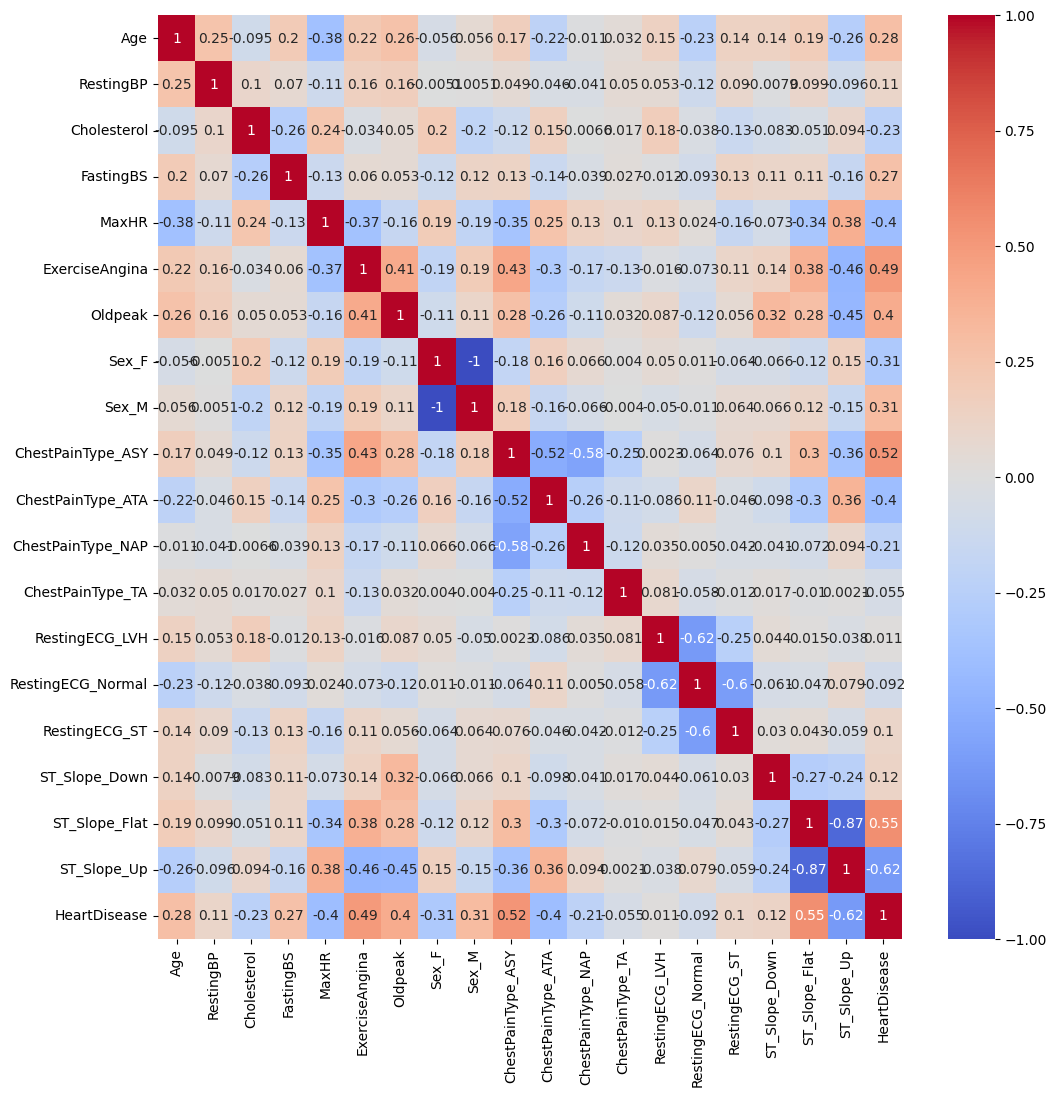

In [11]:
#plot heatmap
plt.figure(figsize=(12, 12))
_ = sns.heatmap(one_hot_heart_disease_df.corr(), annot=True, cmap='coolwarm')

From the heatmap we can notice that our target column (HeartDisease) has strong positive correlations with excercise anigma, old peak, ASY chest pain, and a flat ST slope. We can also take note of positive correlations with Age, fasting BS, and the male sex. While an upward ST slope is the only strong negative correlation, it is important to note that cholesterol and max heart rate also have negative correlations.

<Axes: xlabel='HeartDisease', ylabel='Age'>

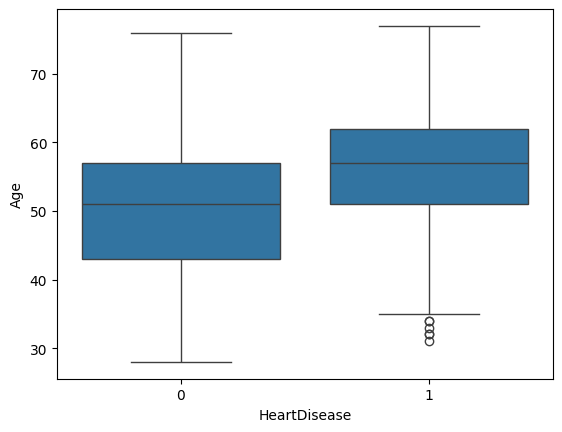

In [12]:
sns.boxplot(x='HeartDisease', y='Age', data=one_hot_heart_disease_df)

By comparing our target (HeartDisease) with age we can notice a clear correlation. Entries with an age of 50 and above seem to be more suseptible to heart disease. Although, it is worth noting that there is a signifficant overlap with those who do not have heart disease aged between approximately 50 and 55. We should also take not of outliers aged around 35 who also have some form of heart disease.

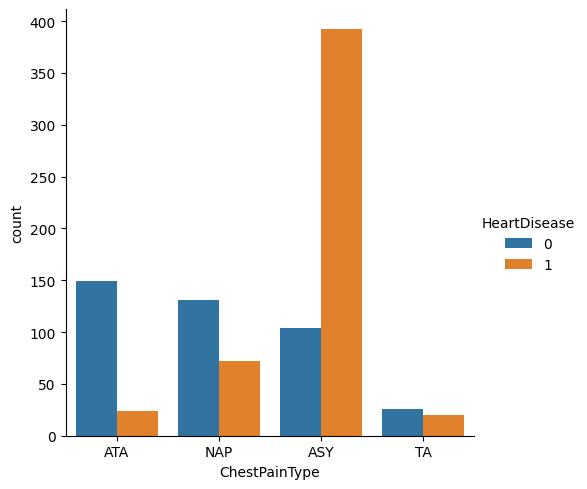

In [13]:
sns.catplot(hue='HeartDisease', x='ChestPainType', data=heart_disease_df, kind='count')

The heatmap revealed a strong correlation with ASY chest pain and heart disease. Exploring this further we also notice that there is a negative correlation with ATA and NAP chest pain. While the correlation with NAP chest pain is weak, it is worth noting that the negative correlation wiht ATA chest pain is quite strong.

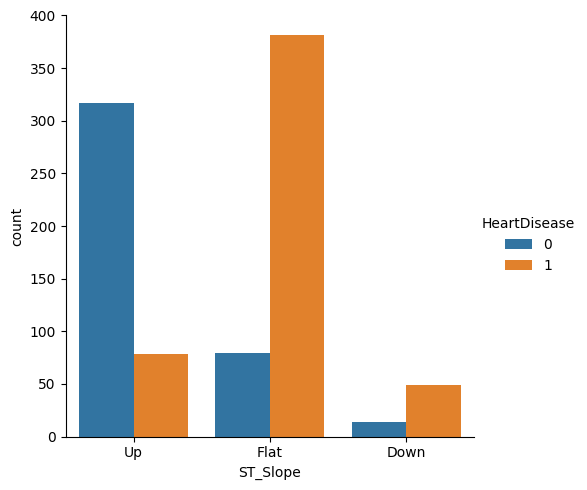

In [14]:
sns.catplot(hue='HeartDisease', x='ST_Slope', data=heart_disease_df, kind='count')

We can explore st slope in a similar fashion to the type of chest pain. ST Slope is a delicate and definite marker of transient myocardial ischemia - a phenomena which occurs when blood flow to the heart is reduced. Looking at the above chart, we can see that it is a robust factor in determining heart disease. We can see clear, strong negative and positive correlations with upward and flat slopes respectively.

# Forecasting

There is no need for any additional preprocessing other splitting our data. Having one hot encoded data, we have good numerical values for forecasting. We will split the data 80/20 for training and testing respectively. Random state will be set arbtitrarily to randomize data.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_heart_disease_df, target, test_size=0.2, random_state=91)

We are going to use 3 models to make our predictions:

* A Logistic Model
* A Random Forest Model
* A Neural Network

For the linear model and the random forest, we are going to leverage scikit-learn's LogisticRegression and RandomForestClassifier respectively. For the neural network we will utilize tensorflow's keras classifier.

# Logistic Model

To begin with we are going to use scikit-learn's GridSearchCV to tune our model. Scikit-learn's LogisticRegression model takes the following parameters:

* penalty: none or string
* dual: boolean
* tol: float
* C: float
* fit_intercept: boolean
* intercept_scaling: float
* random_state: int
* solver: string
* class_weight: dictionary or 'balanced'

For all of the parameters we will specify options aside from the default. For class_weight we will spcecify exclusively the default (none) or 'balanced' as our data does not need to be weighted.


In [16]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

logistic.get_params().keys()

logistic_search = GridSearchCV(logistic, {
    'penalty':['none', 'l1', 'l2'],
    'dual':[True, False],
    'tol':[1e-4, 1e-3, 1e-2],
    'C':[1, 2, 3],
    'fit_intercept':[True, False],
    'intercept_scaling':[1, 2, 3],
    'random_state':[1, 2, 3],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight':['balanced', None]
})

logistic_search.fit(X_train, y_train)

print(logistic_search.best_estimator_)

LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=1,
                   solver='liblinear')


The linear model is fit below using the hyperparameters from the above code block. Note that this may need to be updated depending on the shuffle of the data.

In [17]:
logistic_model = LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=1, solver='liblinear')
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
logistic_predictions

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0], dtype=int64)

# Random Forest



For the random forest, we are going use scikit-learn's RandomForestRegressor. The random forest has more hyper parameters to tune and thus will take much longer to compute. Because of this, we are going to restrict parameters that we pass into our GridSearchCV. The parameters we will be tuning are:

* n_jobs: integer
* max_depth: None, integer
* min_samples_split: integer; at least 2
* min_samples_leaf: integer
* max_features: string



In [18]:
from sklearn.ensemble import RandomForestClassifier

forest_param = GridSearchCV(RandomForestClassifier(), {
    'n_jobs': [1, 2, 3],
    'max_depth': [None, 1, 2],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2']
})

forest_param.fit(X_train, y_train)

print(forest_param.best_estimator_)

RandomForestClassifier(n_jobs=1)


In [19]:
forest = RandomForestClassifier(n_jobs=1)
forest.fit(X_train, y_train)
forest_predictions = forest.predict(X_test)
forest_predictions

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0], dtype=int64)

# Neural Network

Hyperparameter tuning for a neural network is a little more complicated than just using GridSearchCV. Instead we will use our knowledge of neural networks to set the hyperparameters. Since we have a binary target, we want to set the paramters as follows:
* activation = 'sigmoid'
* n_output_units = 1
* loss = "binary_crossentropy"


In [20]:
import keras

def get_clf(meta, hidden_layer_sizes, dropout):
  n_features_in_ = meta['n_features_in_']
  n_classes_ = meta['n_classes_']
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(n_features_in_,)))
  for hidden_layer_sizes in hidden_layer_sizes:
    model.add(keras.layers.Dense(hidden_layer_sizes, activation='relu'))
    model.add(keras.layers.Dropout(dropout))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  return model

In [21]:
from scikeras.wrappers import KerasClassifier

clf = KerasClassifier(
    model = get_clf,
    loss = "binary_crossentropy",
    optimizer = "adam",
    optimizer__learning_rate = 0.001,
    hidden_layer_sizes = (100,),
    dropout = 0.5,
)

With the model defined and the hyperparameters tuned, let's train and test our neural network.

In [22]:
clf.fit(X_train, y_train)
neural_predictions = clf.predict(X_test)
neural_predictions

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 13.4500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0], dtype=int64)

# Validation

We are going to use root mean squared error (RMSE) as our primary metric for evaluating our models. To being, we will implement a simple RMSE function to pass our predictions. RMSE ranges from zero to infinity. The closer the output is to zero, the closer the predictions are to the testing set. A score of 0.0 would mean the predictions are identical to the testing set. Our models will be evaluated as accurate if the RMSE value for the respective model is between 0.2 and 0.5

In [23]:
def root_mean_squared_error(prediction):
  import math
  from sklearn import metrics

  mean_squared_error = metrics.mean_squared_error(y_test, prediction)
  root_mean_squared_error = math.sqrt(mean_squared_error)
  return root_mean_squared_error

In [24]:
root_mean_squared_error(logistic_predictions)

0.0

In [25]:
root_mean_squared_error(forest_predictions)

0.0

In [26]:
root_mean_squared_error(neural_predictions)

0.5366968215490656

Additionally, we will utilize confusion matrices to visualize our predictions. A confusion matrix allows us to categorize our predictions via the following grouping:
* True Negative
* False Positive
* False Negative
* True Positive

In [27]:
def confusion_matrix_calc(prediction):
  from sklearn.metrics import confusion_matrix

  return confusion_matrix(prediction, y_test)

def confusion_matrix_plot(prediction):
  cf_matrix = confusion_matrix_calc(prediction)

  group_names = ['True Negative','False Positive','False Negative','True Positive']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')

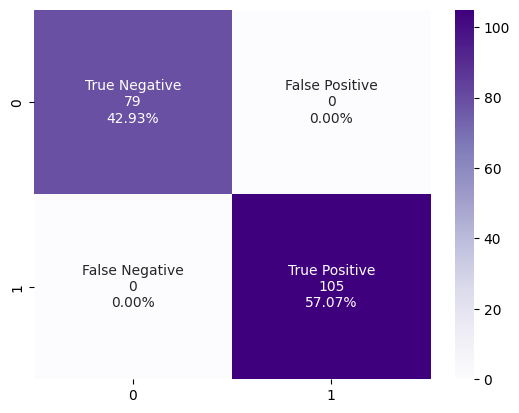

In [28]:
confusion_matrix_plot(logistic_predictions)

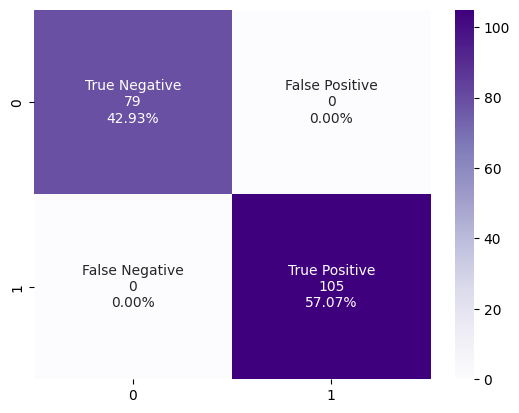

In [29]:
confusion_matrix_plot(forest_predictions)

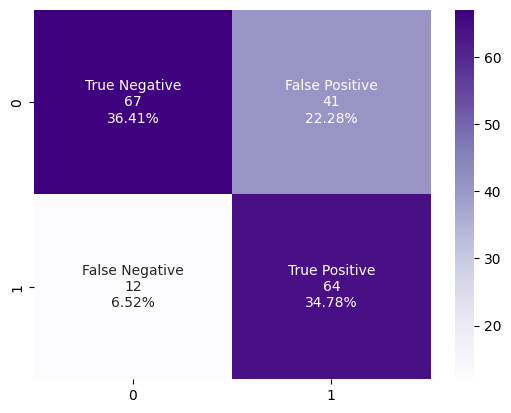

In [30]:
confusion_matrix_plot(neural_predictions)